In [0]:
# !pip install -q tf-nightly

In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import numpy as np
import matplotlib.pyplot as plt

print("Tensorflow Version: {}".format(tf.__version__))
print("GPU {} available.".format("is" if tf.config.experimental.list_physical_devices("GPU") else "not"))

Tensorflow Version: 2.2.0-dev20200205
GPU is available.


# Data Preprocessing

This tutorial uses a filtered version of [Dags vs Cats](https://www.kaggle.com/c/dogs-vs-cats/data) dataset from kaggle.

In [3]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file("cats_and_dogs.zip", origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), "cats_and_dogs_filtered")
PATH

'/root/.keras/datasets/cats_and_dogs_filtered'

In [4]:
!ls -al {PATH}

total 20
drwxr-xr-x 4 root root 4096 Feb  6 06:29 .
drwxr-xr-x 3 root root 4096 Feb  6 06:29 ..
drwxr-xr-x 4 root root 4096 Feb  6 06:29 train
drwxr-xr-x 4 root root 4096 Feb  6 06:29 validation
-rw-r--r-- 1 root root  140 Feb  6 07:44 vectorize.py


The data structure is below.

```text
cats_and_dogs_filtered
|- train +
  |- cats +
    |- xxx.jpg -
    |- xxy.jpg -
  |- dogs +
|- validation +
  |- cats +
  |- dogs +
|- vectorize.py
```

In [5]:
!ls -al {PATH}/train/cats | wc -l

1003


In [0]:
train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

In [0]:
train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')
validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

Understand the dataset.

In [8]:
num_cats_tr = len(os.listdir(train_cats_dir))
num_dogs_tr = len(os.listdir(train_dogs_dir))
num_cats_val = len(os.listdir(validation_cats_dir))
num_dogs_val = len(os.listdir(validation_dogs_dir))

total_train = num_cats_tr + num_dogs_tr
total_val = num_cats_val + num_dogs_val

print("Train: cats {}, dogs {}.".format(num_cats_tr, num_dogs_tr))
print("Validation: cats {}, dogs {}".format(num_cats_val, num_dogs_val))

Train: cats 1000, dogs 1000.
Validation: cats 500, dogs 500


In [0]:
batch_size = 128
epochs = 15
IMG_HEIGHT = 150
IMG_WIDTH = 150

# Data Preparation

In [0]:
# normalize the image
train_img_generator = ImageDataGenerator(rescale=1./255.)
validation_img_generator = ImageDataGenerator(rescale=1./255.)

Load the data from the directory using the generators. (The parameter `directory` set here is the parent's path, not the category ones.)

In [11]:
train_data_gen = train_img_generator.flow_from_directory(
  directory=train_dir, batch_size=batch_size, shuffle=True, 
  target_size=(IMG_HEIGHT, IMG_WIDTH), class_mode='binary')

Found 2000 images belonging to 2 classes.


In [12]:
val_data_gen = validation_img_generator.flow_from_directory(
  directory=validation_dir, batch_size=batch_size, 
  target_size=(IMG_HEIGHT, IMG_WIDTH), class_mode='binary')

Found 1000 images belonging to 2 classes.


## Visualize the Training Images

In [0]:
sample_training_images, sample_training_labels = next(train_data_gen)

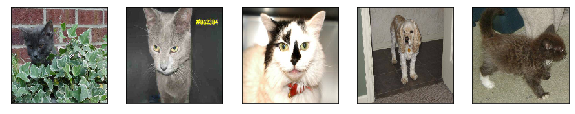

In [14]:
def plotImages(img_arr):
  plt.figure(figsize=(10, 40))
  for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(img_arr[i])
    plt.xticks([])
    plt.yticks([])
  plt.show()

plotImages(sample_training_images)

# Create the Model

In [0]:
def build_model():
  def _model(inputs):
    x = Conv2D(filters=16, kernel_size=(3, 3), padding='same', activation='elu')(inputs)
    x = MaxPooling2D()(x)
    x = Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='elu')(x)
    x = MaxPooling2D()(x)
    x = Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='elu')(x)
    x = MaxPooling2D()(x)
    x = Flatten()(x)
    x = Dense(units=512, activation='elu')(x)
    cls = Dense(units=1, activation='sigmoid')(x)
    return cls

  inputs = tf.keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
  outputs = _model(inputs)
  model = tf.keras.Model(inputs, outputs)
  return model

In [16]:
model = build_model()

model.compile(loss=tf.keras.losses.BinaryCrossentropy(), 
              optimizer=tf.keras.optimizers.Adam(),
              metrics=[tf.keras.metrics.BinaryAccuracy()])

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 150, 150, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 37, 37, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 18, 18, 64)        0     

# Train the Model

In [0]:
history = model.fit(train_data_gen, 
                    steps_per_epoch=total_train // batch_size,
                    epochs=epochs,
                    validation_data=val_data_gen,
                    validation_steps=total_val // batch_size)

# Visualize the Result

In [18]:
history.history.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

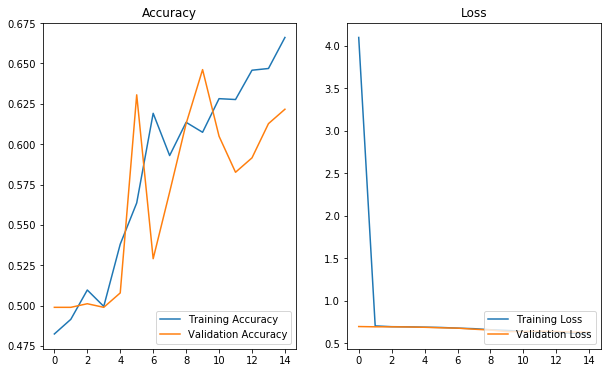

In [19]:
plt.figure(figsize=(10, 6))

plt.subplot(1, 2, 1)
plt.plot(range(epochs), history.history['binary_accuracy'], label='Training Accuracy')
plt.plot(range(epochs), history.history['val_binary_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(epochs), history.history['loss'], label='Training Loss')
plt.plot(range(epochs), history.history['val_loss'], label='Validation Loss')
plt.legend(loc='lower right')
plt.title('Loss')

plt.show()

Let's look at what the wrong is and try to increase the overall performance of the model.

# Overfitting

The above result shows the overfitting of the model that can not perform well on the coming data. Here you can solve the overfitting using the data augmentation and adding a dropout.

# Data Augmentation

The goal is the model will never see the same image twice during training.

## Applying Horizontal Flip

In [0]:
image_gen = ImageDataGenerator(rescale=1./255., horizontal_flip=True)

In [21]:
train_data_gen = image_gen.flow_from_directory(
  directory=train_dir, batch_size=batch_size, target_size=(IMG_HEIGHT, IMG_WIDTH),
  shuffle=True)

Found 2000 images belonging to 2 classes.


In [0]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]

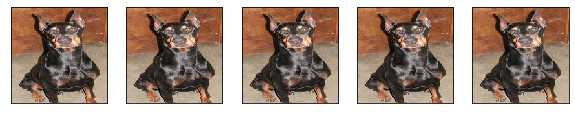

In [23]:
plotImages(augmented_images)

## Applying Randomly Rotations

In [0]:
image_gen = ImageDataGenerator(rescale=1./255., rotation_range=45)

In [25]:
train_data_gen = image_gen.flow_from_directory(
  directory=train_dir, batch_size=batch_size, target_size=(IMG_HEIGHT, IMG_WIDTH),
  shuffle=True
)

Found 2000 images belonging to 2 classes.


In [0]:
augmented_images = [train_data_gen[0][0][0] for _ in range(5)]

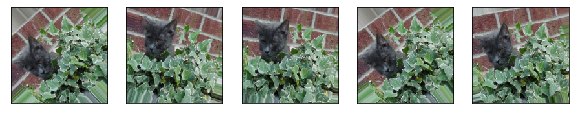

In [27]:
plotImages(augmented_images)

## Applying Zooming

In [0]:
# zoom range from 0 to 1 represents 0% to 100%
image_gen = ImageDataGenerator(rescale=1./255., zoom_range=0.5)

In [29]:
train_data_gen = image_gen.flow_from_directory(
  directory=train_dir, batch_size=batch_size, target_size=(IMG_HEIGHT, IMG_WIDTH),
  shuffle=True
)

Found 2000 images belonging to 2 classes.


In [0]:
augmented_images = [train_data_gen[0][0][0] for _ in range(5)]

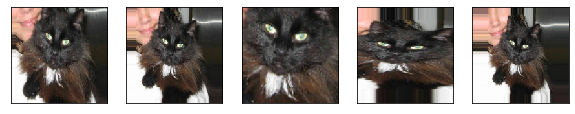

In [31]:
plotImages(augmented_images)

## Combining Augmentation Methods

In [0]:
image_gen = ImageDataGenerator(
  rescale=1./255., 
  horizontal_flip=True, 
  rotation_range=45, 
  zoom_range=0.5, 
  width_shift_range=.15, 
  height_shift_range=.15)

In [33]:
train_data_gen = image_gen.flow_from_directory(
  directory=train_dir, batch_size=batch_size, target_size=(IMG_HEIGHT, IMG_WIDTH),
  shuffle=True, class_mode='binary')

Found 2000 images belonging to 2 classes.


In [0]:
augmented_images = [train_data_gen[0][0][0] for _ in range(5)]

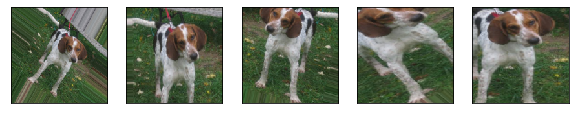

In [35]:
plotImages(augmented_images)

## Creating a Validation Dataset Generator

Normally only the training dataset generator would be applied with the augmentation methods. On contrast, the validation dataset generator would not be augmented.

In [0]:
image_gen_val = ImageDataGenerator(rescale=1./255.)

In [37]:
val_data_gen = image_gen_val.flow_from_directory(
  directory=validation_dir, batch_size=batch_size, target_size=(IMG_HEIGHT, IMG_WIDTH), 
  class_mode='binary')

Found 1000 images belonging to 2 classes.


# Dropout

The `dropout` is a form of regularization. It forces the model to use a small part of weights to do the prediction. When the dropout rate is set to 0.1, it means 10% output nodes are randomly set to zero (be dropped) in each epoch of training. 

## A Model with the Dropout Layer

In [0]:
def build_model_dropout():
  def _model(inputs):
    x = Conv2D(filters=16, kernel_size=(3, 3), activation='elu',
               padding='same')(inputs)
    x = MaxPooling2D()(x)
    # keras handles the dropout rate in training or inference phrase
    x = Dropout(0.2)(x)
    x = Conv2D(filters=32, kernel_size=(3, 3), activation='elu', 
               padding='same')(x)
    x = MaxPooling2D()(x)
    x = Conv2D(filters=64, kernel_size=(3, 3), activation='elu', 
               padding='same')(x)
    x = MaxPooling2D()(x)
    x = Dropout(0.2)(x)
    x = Flatten()(x)
    x = Dense(units=512, activation='elu')(x)
    cls = Dense(units=1, activation='sigmoid')(x)
    return cls

  inputs = tf.keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
  outputs = _model(inputs)
  model = tf.keras.Model(inputs, outputs)
  return model

In [39]:
model_new = build_model_dropout()

model_new.compile(loss=tf.keras.losses.BinaryCrossentropy(), 
              optimizer=tf.keras.optimizers.Adam(), 
              metrics=[tf.keras.metrics.BinaryAccuracy()])

model_new.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 150, 150, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 75, 75, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 75, 75, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 75, 75, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 37, 37, 64)        1849

## Train the Model

In [0]:
history = model_new.fit(train_data_gen, 
                    steps_per_epoch=total_train // batch_size, 
                    epochs=epochs, 
                    validation_data=val_data_gen,
                    validation_steps=total_val // batch_size)

In [41]:
history.history.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

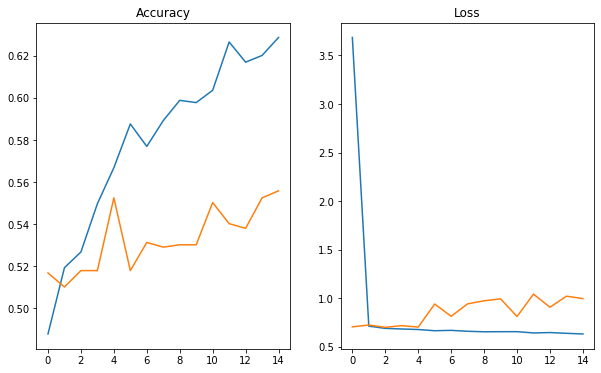

In [42]:
plt.figure(figsize=(10, 6))

plt.subplot(1, 2, 1)
plt.plot(range(epochs), history.history['binary_accuracy'], label='Training')
plt.plot(range(epochs), history.history['val_binary_accuracy'], label='Validation')
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(epochs), history.history['loss'], label='Training')
plt.plot(range(epochs), history.history['val_loss'], label='Validation')
plt.title('Loss')

plt.show()